## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

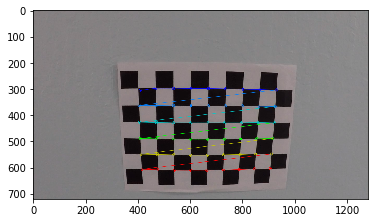

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
i = 0

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        out_name = 'calibrated' +str(i) +'.jpg'
        cv2.imwrite('output_images/calibration_output/'+ out_name, img)
        plt.imshow(img)

## Correct Distortion and Output Images

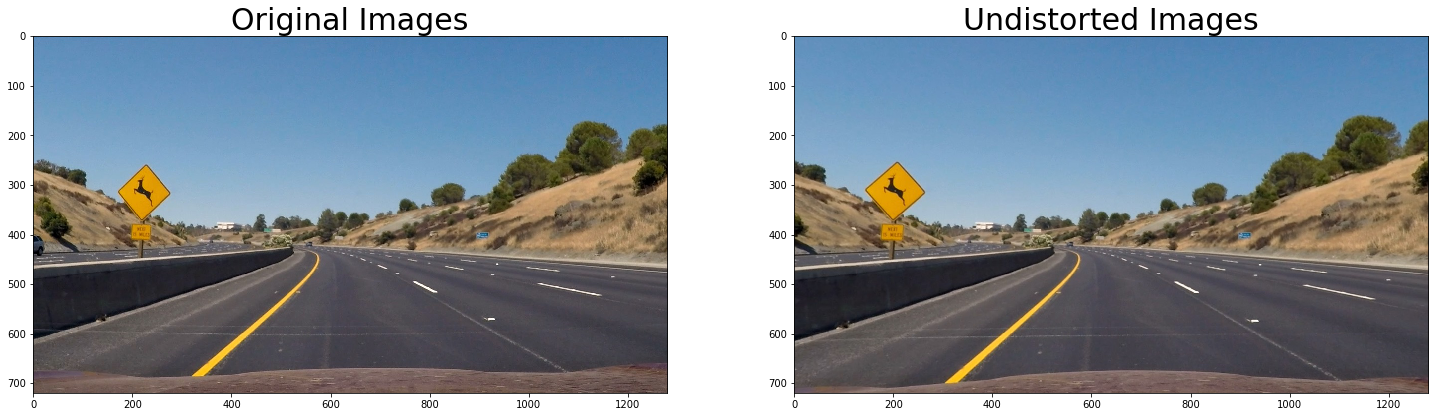

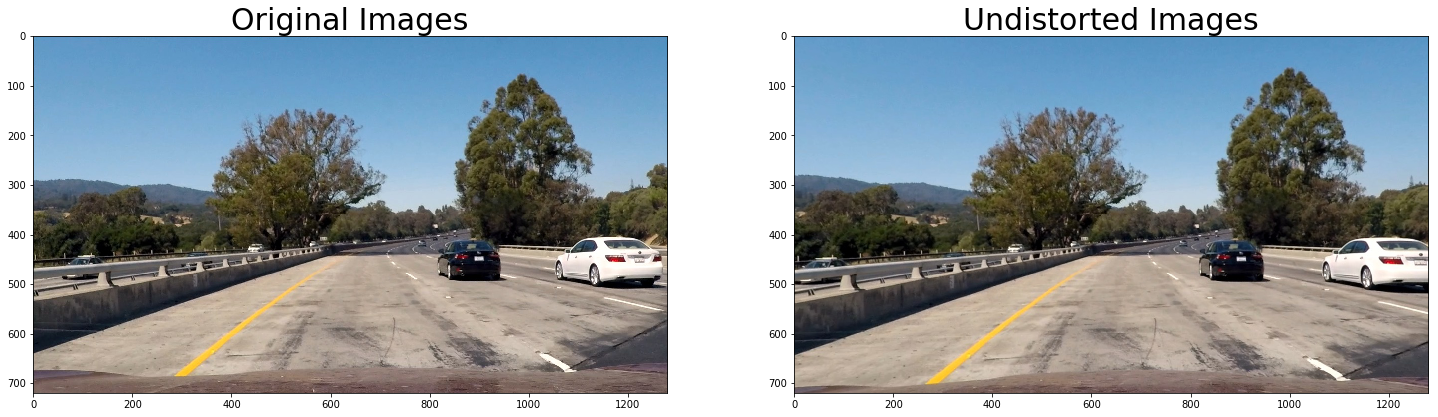

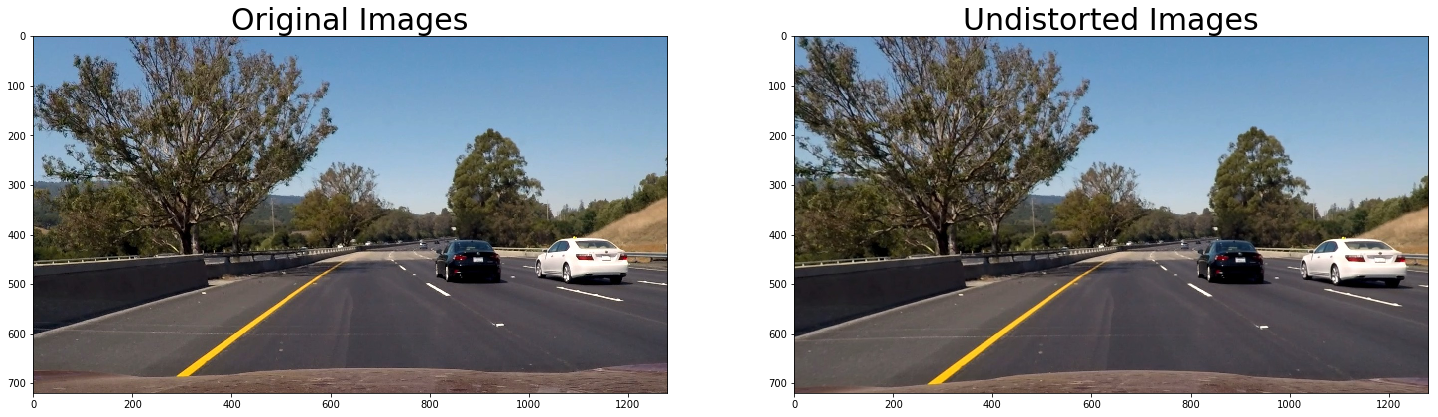

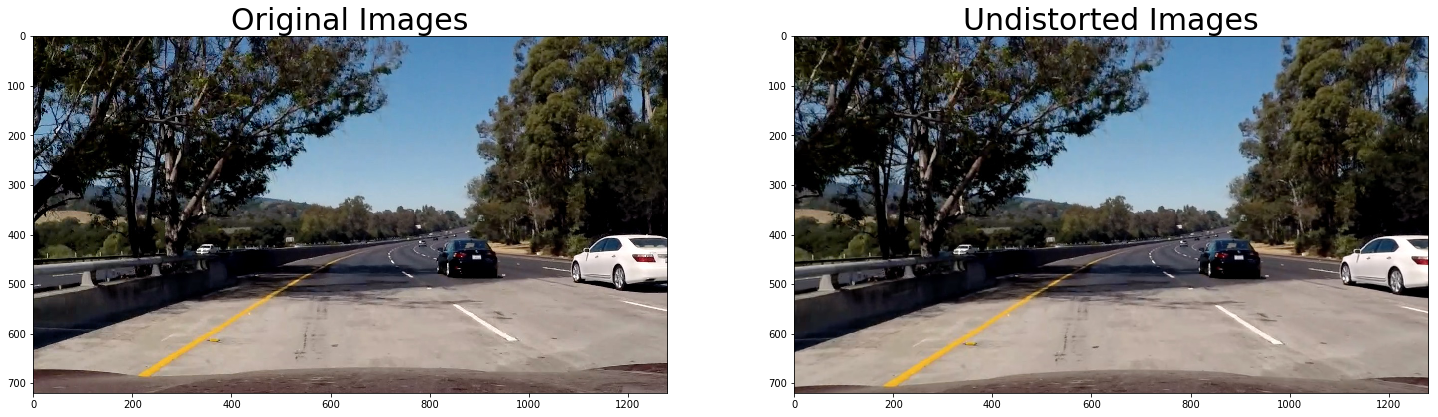

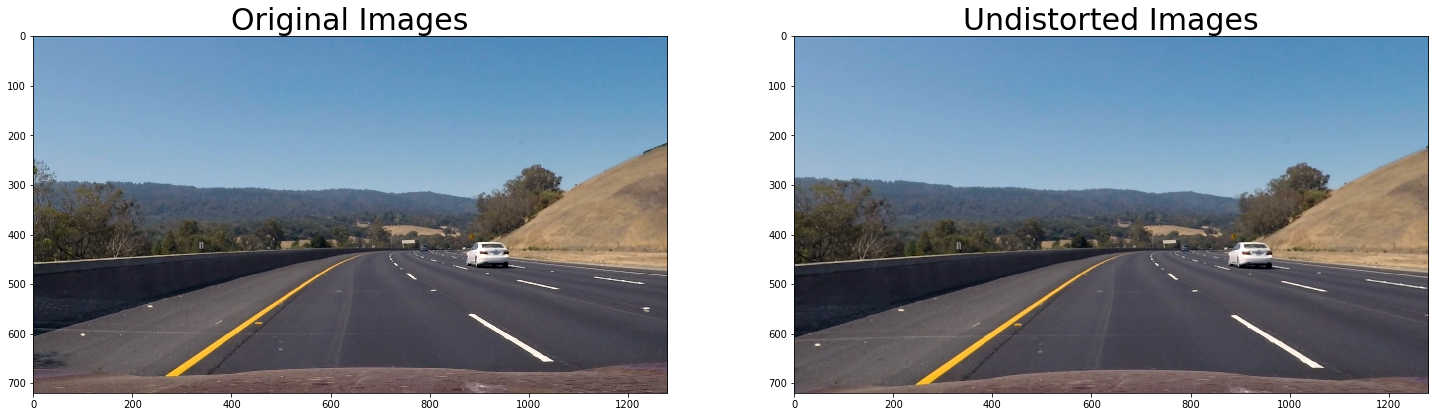

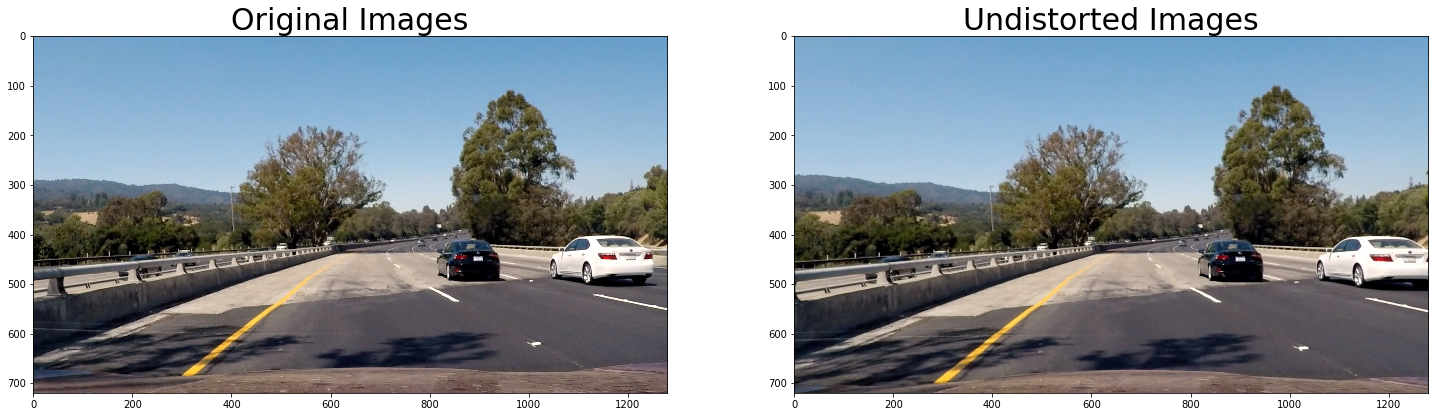

In [2]:
# Undistorts the image
def undistort_image(img):
    image_shape = (img.shape[1], img.shape[0])
    
    # Use the calibrateCamera function to retrieve necessary variables for undistortion
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    
    # Undistort the image using the variables retrieved above
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist
    
# Function that displays and saves the images
def display_and_save(images):
    for i, fname in enumerate(images):
        image = cv2.imread(fname)
        undistorted_im = undistort_image(image)

        # Displays the image
        # Left column displays the original image
        # Right column displays the undistorted image
        f, (original, undistorted) = plt.subplots(1, 2, figsize=(25,10))
        original.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        original.set_title('Original Images', fontsize=30)
        undistorted.imshow(cv2.cvtColor(undistorted_im, cv2.COLOR_BGR2RGB))
        undistorted.set_title('Undistorted Images', fontsize=30)

        # Saves the undistorted images to the output_images/undistorted_images directory
        write_name = 'undistorted'+str(i)+'.jpg'
        cv2.imwrite('output_images/undistorted_images/'+write_name, undistorted_im)
        
# Function that only saves the images
def save(images):
    for i, fname in enumerate(images):
        image = cv2.imread(fname)
        undistorted_im = undistort_image(image)

        # Saves the undistorted images to the output_images/undistorted_images directory
        out_name = 'undistorted'+str(i)+'.jpg'
        cv2.imwrite('output_images/undistorted_images/'+out_name, undistorted_im)
    
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
display_and_save(images)

## Threshold Images

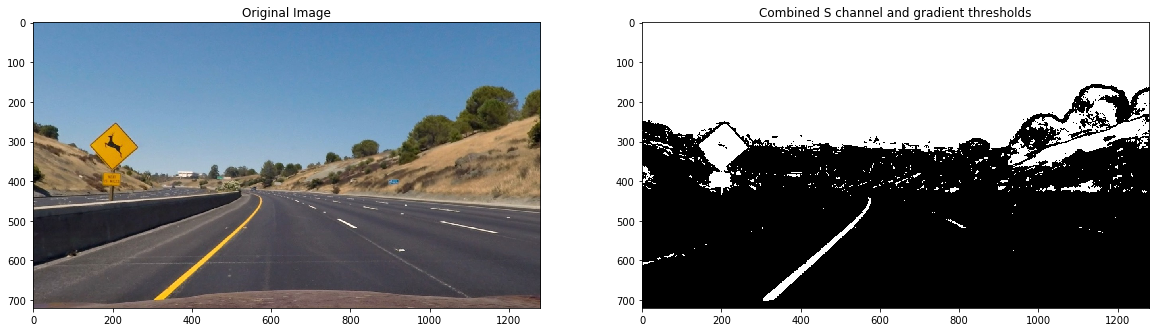

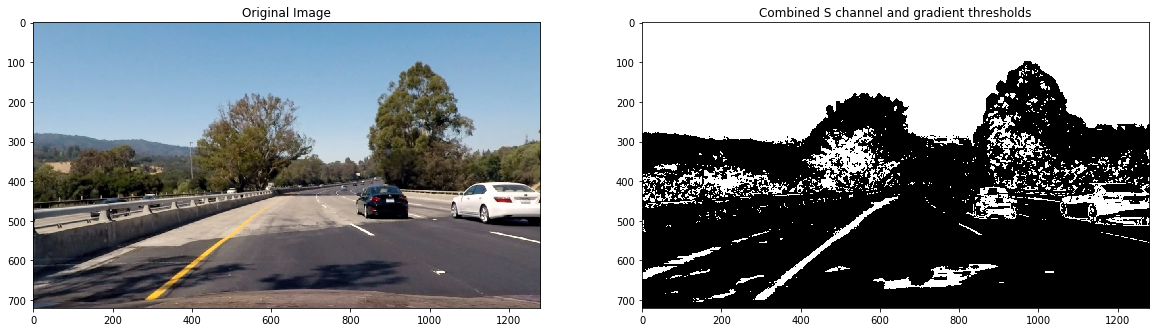

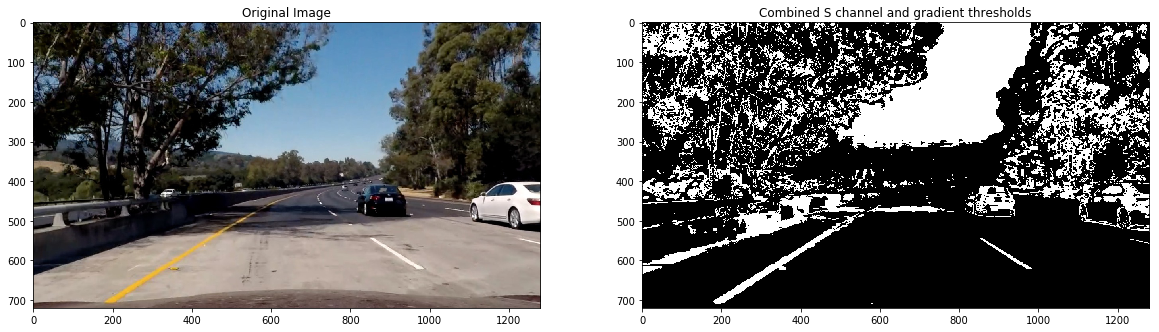

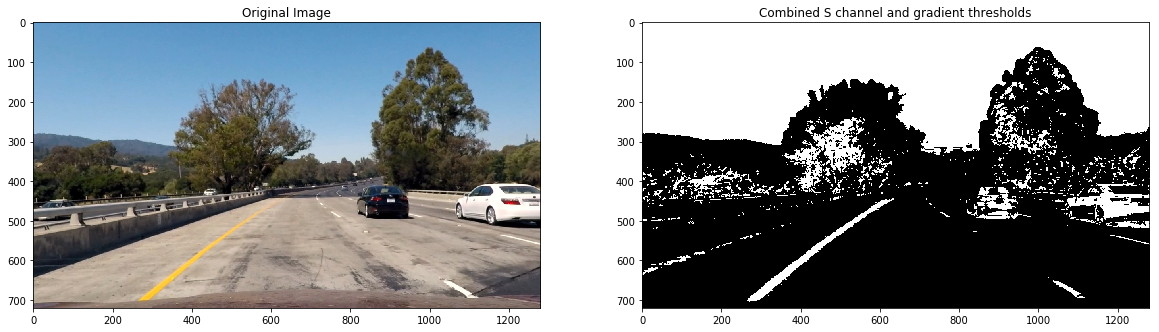

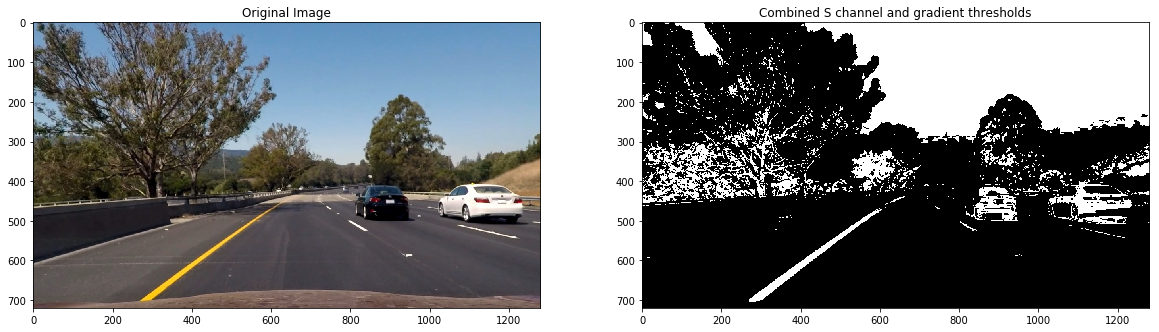

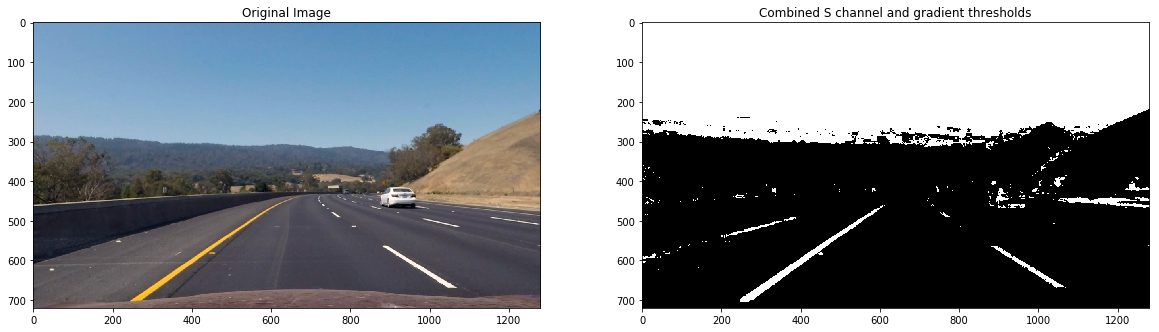

In [3]:
def threshold_image(img, s_thresh=(90, 255), sx_thresh=(100, 255), l_thresh=(90,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sx_thresh_min = sx_thresh[0]
    sx_thresh_max = sx_thresh[1]
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh_min) & (scaled_sobel <= sx_thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    color_binary = np.dstack((np.zeros_like(sx_binary), s_binary, sx_binary)) * 255 
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    
    return combined_binary

def display_and_save(images): 
    for i, fname in enumerate(images):
        image = cv2.imread(fname)
        image_threshold = threshold_image(image)

        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Original Image')
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(image_threshold, cmap='gray')

        write_name = 'thresholded'+str(i)+'.jpg'
        cv2.imwrite('output_images/thresholded_images/'+write_name, image_threshold*255)

# Make a list of undistorted images
images = glob.glob('output_images/undistorted_images/undistorted*.jpg')
display_and_save(images)

## Birds Eye Perspective Transform

In [9]:
from matplotlib.patches import Polygon

def birds_eye_transform(image):
    image_shape = (img.shape[1], img.shape[0])
    offset = 0
    
    src = np.float32(
        [[220,720],  # Bottom Left
         [570, 470],  # Top Left
         [725, 470],  # Top Right
         [1110, 720]]) # Bottom Right
        
    dst = np.float32(
        [[320,720],  # Bottom Left
         [320, 0],  # Top Left
         [920, 0],  # Top Right
         [920, 720]]) # Bottom Right   
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped_image = cv2.warpPerspective(image, M, image_shape)
    
def display_and_save(images): 
    for i, fname in enumerate(images):
        image = cv2.imread(fname)
        birds_eye_image = birds_eye_transform(image)

        write_name = 'warped'+str(i)+'.jpg'
        cv2.imwrite('output_images/warped_images/'+write_name, birds_eye_image)

# Make a list of undistorted images
images = glob.glob('output_images/thresholded_images/thresholded*.jpg')
display_and_save(images)

## Create Histogram of Warped Image

In [7]:
def create_histogram(image):
    # Grab only the bottom half of the image
    bottom_half = image[image.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    return histogram


images = glob.glob('output_images/warped_images/warped*.jpg')
for i, fname in enumerate(images):
    image = cv2.imread(fname)/255
    image_hist = create_histogram(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Warped Image', fontsize=20)
    ax2.plot(image_hist)
    ax2.set_title('Histogram of Image', fontsize=20)

AttributeError: 'NoneType' object has no attribute 'shape'

## Split Histogram for Each Line and Create Sliding Windows

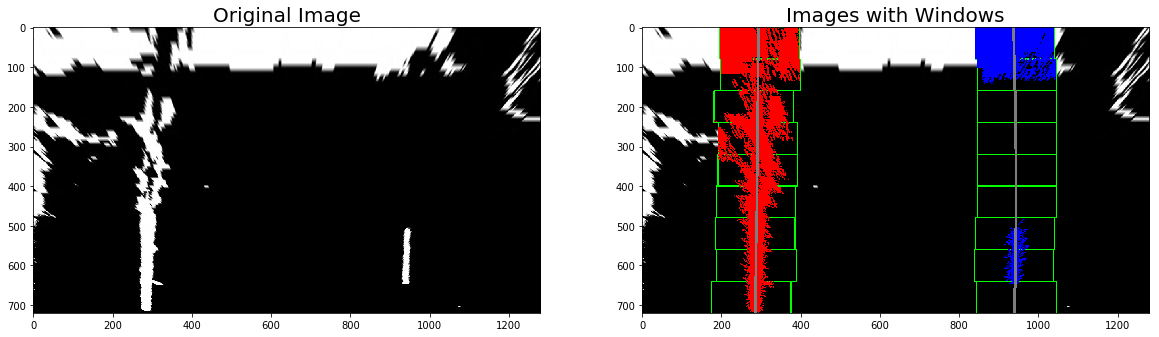

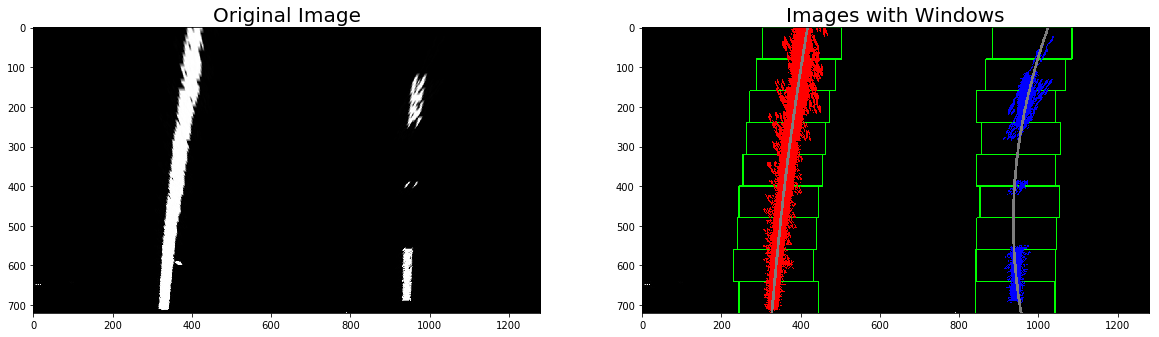

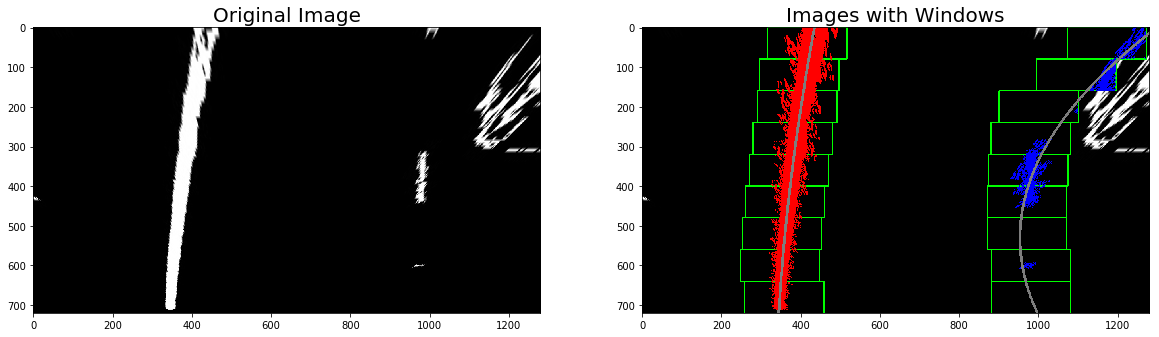

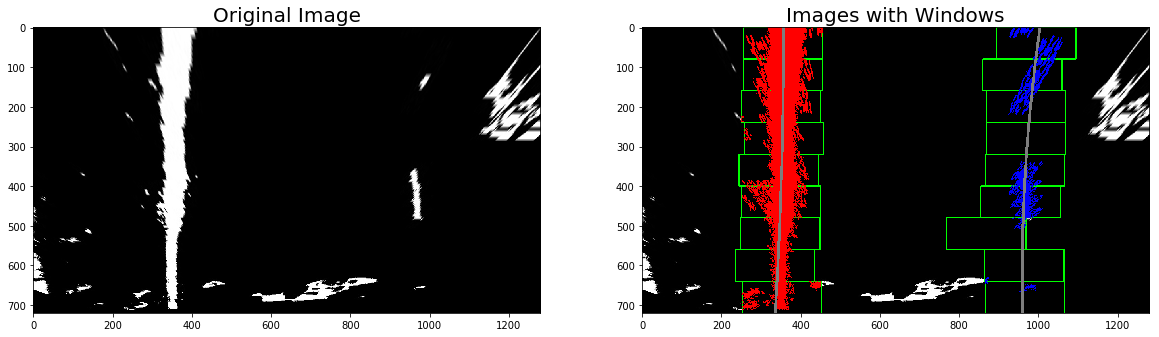

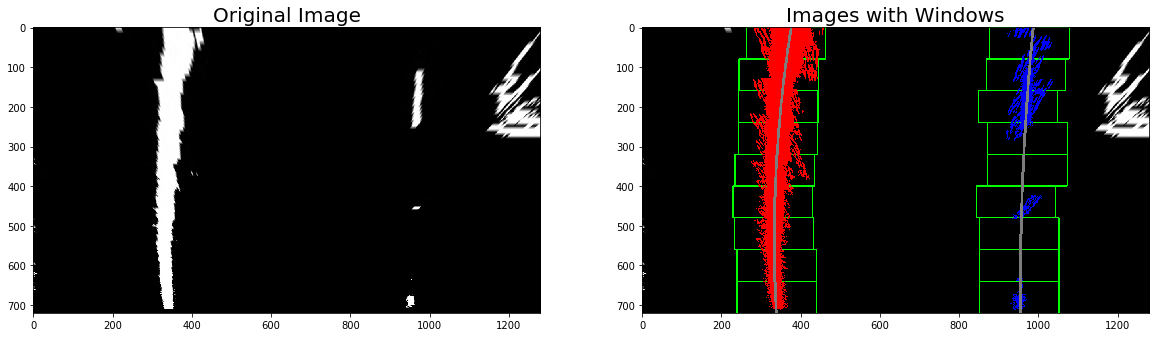

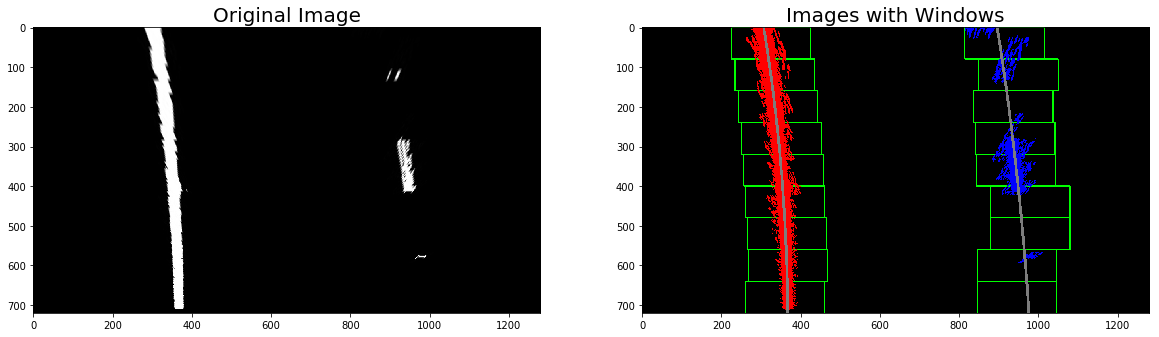

In [40]:
def find_lane_pixels(binary_warped):
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY) 
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low, win_y_low), (win_xright_high, win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found pixels > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    #Creates a polynomial line for each lane with input of (out_img, start_point, end_point, color, thickness)
    for point in range(len(ploty[:-1])):
        cv2.line(out_img,(int(left_fitx[point]),int(ploty[point])),
                 (int(left_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)
        cv2.line(out_img,(int(right_fitx[point]),int(ploty[point])),
                 (int(right_fitx[point+1]),int(ploty[point+1])),(125, 125, 125),5)

    return out_img

def display_and_save(images): 
    for i, fname in enumerate(images):
        image = cv2.imread(fname)
        window_poly_image = fit_polynomial(image)

        # Plotting window and polynomial fitted images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Original Image', fontsize=20)
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax2.set_title('Images with Windows', fontsize=20)
        ax2.imshow(window_poly_image, cmap='gray')

        write_name = 'window_poly_image'+str(i)+'.jpg'
        cv2.imwrite('output_images/windowed_images/'+write_name, window_poly_image*255)

# Make a list of undistorted images
images = glob.glob('output_images/warped_images/warped*.jpg')
display_and_save(images)

## Determine the curvature of the lane and vehicle position with respect to center.


In [43]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result
        
images = glob.glob('output_images/warped_images/warped*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    poly_image = search_around_poly(image)
    
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Warped Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(poly_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('Windows and Lanes', fontsize=20)
    ax3.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax3.set_title('Transformed', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    #write_name = 'polysearch'+str(idx)+'.jpg'
    #cv2.imwrite('output_images/'+write_name, image_aroundpoly[0])
    #write_name = 'final'+str(idx)+'.jpg'
    #cv2.imwrite('output_images/'+write_name, image_aroundpoly[1])

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (163908,9)